# Plottinfg

This script reproduces the plots from the paper. All its contents are described in 2 and 3.

In [1]:
import os
import pickle
import fastdtw
import Levenshtein
import numpy as np
import pandas as pd
import seaborn as sns
import textdistance
import tensorflow as tf

from matplotlib import pyplot as plt
from stellargraph.mapper import FullBatchNodeGenerator, CorruptedGenerator
from stellargraph.layer import GCN, DeepGraphInfomax
from stellargraph.utils import plot_history

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, adjusted_rand_score
from sklearn.preprocessing import MultiLabelBinarizer

from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

2024-12-13 19:16:32.931385: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 19:16:32.933593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 19:16:32.971724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 19:16:32.973366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 19:16:33.809801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
def run_deep_graph_infomax(G, layer_sizes=None, activations=None, epochs=None, learning_rate=None, pat = None, history_plot=False):
    # Create a full batch generator
    fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)

    # Define the GCN model
    gcn_model = GCN(layer_sizes=layer_sizes, activations=activations, generator=fullbatch_generator)

    # Create a corrupted generator for DeepGraphInfomax
    corrupted_generator = CorruptedGenerator(fullbatch_generator)
    gen = corrupted_generator.flow(G.nodes())

    # Create a DeepGraphInfomax model
    infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(learning_rate=learning_rate))

    # Train the model
    es = EarlyStopping(monitor="loss", min_delta=0, patience=pat)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es, lr_scheduler])

    if history_plot:
        plot_history(history)
        print(f"Final loss: {history.history['loss'][-1]}")

    # Create an embedding model
    x_emb_in, x_emb_out = gcn_model.in_out_tensors()
    x_out = tf.squeeze(x_emb_out, axis=0)
    emb_model = Model(inputs=x_emb_in, outputs=x_out)

    # Predict embeddings for all nodes
    embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes())[0][0])
    return embeddings

def lr_schedule(epoch, lr):
    # Decrease learning rate by 10% every 10 epochs
    if epoch % 10 == 0 and epoch:
        return lr * 0.9
    return lr

In [3]:
wd = os.getcwd()

gcn_data = f"{wd}/multiverse/data/graph_and_embeddings_paper.pkl"
with open(gcn_data, 'rb') as file:
    loaded_variables = pickle.load(file)

# Load embeddings
G = loaded_variables["G"]
G_nx = loaded_variables["G_nx"]
nodes = loaded_variables["nodes"]
node_features = loaded_variables["node_features"]
embeddings = loaded_variables["embeddings"]
embeddings_dict = {label: emb for label, emb in zip(nodes, embeddings)}


pipeline_df = pd.read_excel(f'{wd}/data/Database_clean.xlsx')
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
authors = [pipeline[0] for pipeline in pipelines]
pipelines = [pipeline[1:] for pipeline in pipelines]

# Create a dictionary to map node labels to their embeddings
embedding_dict = {label: emb for label, emb in zip(nodes, embeddings)}

# Aggregate embeddings for each pipeline -> average over all nodes in the pipelines to get a single feature vector
pipeline_embeddings = []
for pipeline in pipelines:
    pipeline_embs = [embedding_dict[node] for node in pipeline if node in embedding_dict]
    joint_embedding = np.mean(pipeline_embs, axis=0)  # or np.sum(pipeline_embs, axis=0)
    pipeline_embeddings.append(np.mean(pipeline_embs, axis=0))

joint_embeddings = pd.DataFrame(pipeline_embeddings, index=authors)


In [4]:
def dtw_reduce(data):
    num_features, _ = data.shape
    reference_sequence = np.mean(data, axis=0)  # Use mean sequence as reference
    dtw_distances = np.zeros(num_features)

    for i in range(num_features):
        distance, _ = fastdtw.fastdtw(data[i], reference_sequence)
        dtw_distances[i] = distance

    return dtw_distances

# Joint embeddings with dynamic time warping
pipeline_embeddings_dtw = []
for pipeline in pipelines:
        pipeline_embs = [embedding_dict[node] for node in pipeline if node in embedding_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

# Convert the result to a DataFrame for inspection
joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw, index=authors)

In [5]:
# Mean embeddings: Calculate the dissimilarity matrix and scale to convert it to a similarity matrix
dissimilarity_matrix = squareform(pdist(joint_embeddings, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity = 1 - scaled_dissimilarity_matrix

# Perform hierarchical clustering on the similarity matrix
row_linkage = linkage(embedding_similarity, method='average', metric='euclidean')
col_linkage = linkage(embedding_similarity.T, method='average', metric='euclidean')
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# DTW embeddings
dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

# Levenshtein distance
n = len(pipelines)
levenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

min_val = np.min(levenshtein_distance)
max_val = np.max(levenshtein_distance)
scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
levenshtein_similarity = 1 - scaled_levenshtein_distance

# Hamming distance
n = len(pipelines)
hamming_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

min_val = np.min(hamming_distance)
max_val = np.max(hamming_distance)
scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
hamming_similarity = 1 - scaled_hamming_distance

# DamerauLevenshtein distance
n = len(pipelines)
DamerauLevenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            DamerauLevenshtein_distance[i, j] = textdistance.damerau_levenshtein(pipelines[i], pipelines[j])


min_val = np.min(DamerauLevenshtein_distance)
max_val = np.max(DamerauLevenshtein_distance)
scaled_DamerauLevenshtein_distance = (DamerauLevenshtein_distance - min_val) / (max_val - min_val)
DamerauLevenshtein_similarity = 1 - scaled_DamerauLevenshtein_distance

# Jaccard distance
mlb = MultiLabelBinarizer()
pipeline_binary = mlb.fit_transform(pipelines)
jaccard_similarity = 1 - pairwise_distances(pipeline_binary, metric="jaccard")

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [6]:
triu_indices = np.triu_indices_from(embedding_similarity, k=1)
upper_triangle_embeddings = embedding_similarity[triu_indices]
upper_triangle_embeddings_dtw = embedding_similarity_dtw[triu_indices]
upper_triangle_hamming = hamming_similarity[triu_indices]
upper_triangle_levenshtein = levenshtein_similarity[triu_indices]
upper_triangle_jaccard = jaccard_similarity[triu_indices]
upper_triangle_dameraulevenshtein = DamerauLevenshtein_similarity[triu_indices]

# Create a DataFrame with the upper triangle similarities
similarity_data = pd.DataFrame({
    'Jaccard': upper_triangle_jaccard,
    'GCN-embedings': upper_triangle_embeddings_dtw,
    'Hamming': upper_triangle_hamming,
    'Levenshtein': upper_triangle_levenshtein,
    'DamerauLevenshtein': upper_triangle_dameraulevenshtein
})

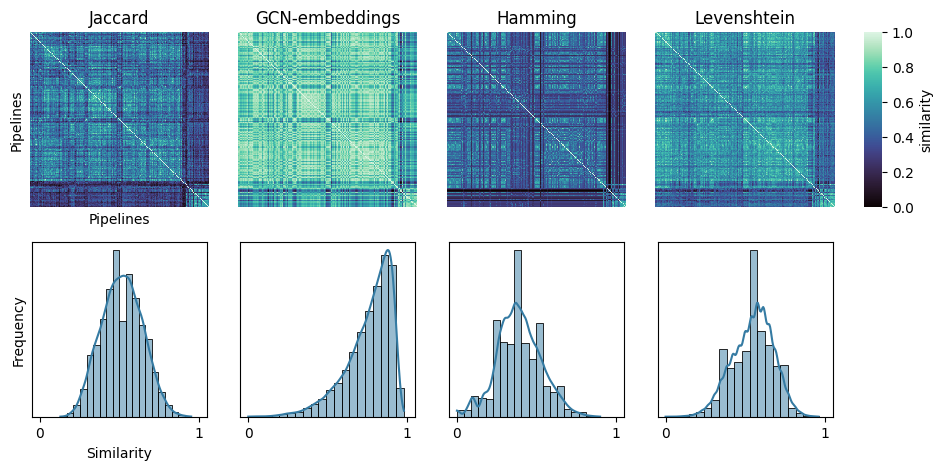

In [7]:
import matplotlib
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(11, 5))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.1], figure=fig)

# Similarity matrix data and titles
similarity_matrices = [
    (jaccard_similarity, 'Jaccard'),
    (embedding_similarity_dtw, 'GCN-embeddings'),
    (hamming_similarity, 'Hamming'),
    (levenshtein_similarity, 'Levenshtein')
]

# Plot similarity matrices
axes = []
cbar_ax = fig.add_subplot(gs[0, 4])  # Reserve space for the colorbar
for i, (matrix, title) in enumerate(similarity_matrices):
    ax = fig.add_subplot(gs[0, i])
    sns.heatmap(matrix[np.ix_(row_order, col_order)], cmap='mako', cbar=(i == 3), 
                cbar_ax=cbar_ax if i == 3 else None, cbar_kws={'label': 'similarity'}, ax=ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    if i == 0:
        ax.set_ylabel('Pipelines')
        ax.set_xlabel('Pipelines')
    axes.append(ax)

# Histogram data and labels
histogram_data = [
    ('Jaccard', 'Frequency', 'Similarity'),
    ('GCN-embedings', '', ''),
    ('Hamming', '', ''),
    ('Levenshtein', '', '')
]

# Plot histograms
mako_cmap = matplotlib.colormaps.get_cmap('mako')
middle_color = mako_cmap(0.5)

for i, (key, ylabel, xlabel) in enumerate(histogram_data):
    ax = fig.add_subplot(gs[1, i])
    sns.histplot(data=similarity_data[key], kde=True, bins=20, ax=ax, color=middle_color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim([-0.05, 1.05])
    ax.set_yticks([])
    ax.set_xticks([0, 1])
    ax.set_box_aspect(1)

plt.savefig("figures/similarity.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()

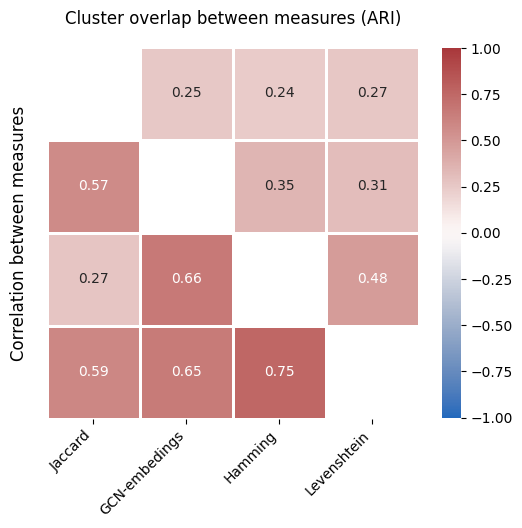

In [8]:
# Based on visual inspectiuon, we choose 4 clusters for ARI calculations
num_clusters = 4
similarity_matrices = [jaccard_similarity, embedding_similarity_dtw, hamming_similarity, levenshtein_similarity, DamerauLevenshtein_similarity]
similarity_matrix_names = ['Jaccard', 'GCN-embedings', 'Hamming', 'Levenshtein', 'Damerau Levenshtein']

# Initialize an empty dataframe to store the cluster results
cluster_results = pd.DataFrame(index=range(1, len(pipelines) + 1))

# Perform k-means clustering and store the assigned groups for each similarity matrix
for i, similarity_matrix_name in enumerate(similarity_matrix_names):
    kmeans = KMeans(n_clusters=num_clusters, random_state=29, n_init=10)
    kmeans.fit(similarity_matrices[i])
    labels = kmeans.labels_

    cluster_results[similarity_matrix_name] = labels

# Calculate the Adjusted Rand Index (ARI) for each similarity matrix
ari_matrix = np.zeros((len(similarity_matrices), len(similarity_matrices)))
for i in range(len(similarity_matrices)):
    for j in range(len(similarity_matrices)):
        ari = adjusted_rand_score(cluster_results[similarity_matrix_names[i]], cluster_results[similarity_matrix_names[j]])
        ari_matrix[i, j] = ari

# Convert the ARI matrix to a DataFrame for better visualization
ari_matrix_df = pd.DataFrame(ari_matrix, index=similarity_matrix_names, columns=similarity_matrix_names)

# Count the number of pipelines in each cluster for each similarity matrix
cluster_counts = cluster_results.apply(lambda x: x.value_counts()).T
df = pd.DataFrame(cluster_counts.values, index=similarity_matrix_names, columns=[f'Cluster {i+1}' for i in range(num_clusters)])


# Calculate the correlation matrix
correlation_matrix = similarity_data.corr()

# Plotting
upper_triangle_indices = np.triu_indices_from(correlation_matrix, k=1)
lower_triangle_indices = np.tril_indices_from(correlation_matrix, k=-1)

combined_matrix = np.zeros_like(correlation_matrix, dtype=float)
mask = np.eye(correlation_matrix.shape[0], dtype=bool)

combined_matrix[upper_triangle_indices] = ari_matrix_df.values[upper_triangle_indices]
combined_matrix[lower_triangle_indices] = correlation_matrix.values[lower_triangle_indices]

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Create the heatmap
sns.heatmap(
    combined_matrix[:4,:4],
    mask=mask[:4,:4],
    annot=True,
    cmap='vlag',
    cbar_kws={'shrink': 0.8},
    cbar=True,
    vmin=-1,
    vmax=1,
    square=True,
    xticklabels=similarity_matrix_names[:4],
    yticklabels=[],
    ax=ax,
    linewidths=1
)

# Add ARI and Correlation labels for the triangles
ax.text(len(similarity_matrix_names[:4]) / 2, -0.3, "Cluster overlap between measures (ARI)", 
        ha="center", va="center", fontsize=12, color="black")

ax.text(-0.3, len(similarity_matrix_names[:4]) / 2, "Correlation between measures", 
        ha="center", va="center", fontsize=12, color="black", rotation=90)

# Adjust the ticks
ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_ha('right')

plt.savefig("figures/matrix.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()

## Multiverse analysis evaluation

In [9]:
import os
import pickle
import fastdtw
import Levenshtein
import numpy as np
import pandas as pd
import ptitprince as pt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

wd = os.getcwd()

file_paths = [f"{wd}/multiverse/multiverse_pipelines/results/universe_{i}.pkl" for i in range(1, 17)]
gcn_data = f"{wd}/multiverse/data/graph_and_embeddings_paper.pkl" 
pipeline_path = f"{wd}/multiverse/data/pipelines_multiverse.xlsx"

In [10]:
universes_data = []
for file_path in file_paths:
    with open(file_path, 'rb') as file:
        universe = pickle.load(file)
        universes_data.append(list(universe.values()))

empirical_similarity = np.corrcoef(np.array(universes_data))

In [11]:
with open(gcn_data, 'rb') as file:
    loaded_variables = pickle.load(file)

# Load embeddings
G = loaded_variables["G"]
G_nx = loaded_variables["G_nx"]
nodes = loaded_variables["nodes"]
node_features = loaded_variables["node_features"]
embeddings = loaded_variables["embeddings"]
embeddings_dict = {label: emb for label, emb in zip(nodes, embeddings)}

# Load pipelines
pipeline_df = pd.read_excel(pipeline_path, index_col=0)
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

In [12]:
def dtw_reduce(data):
    num_features, _ = data.shape
    reference_sequence = np.mean(data, axis=0)
    dtw_distances = np.zeros(num_features)

    for i in range(num_features):
        distance, _ = fastdtw.fastdtw(data[i], reference_sequence)
        dtw_distances[i] = distance

    return dtw_distances

# GCN
pipeline_embeddings_dtw = []
for pipeline in pipelines:
        pipeline_embs = [embeddings_dict[node] for node in pipeline if node in embeddings_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw)

dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
gcn_similarity = 1 - scaled_dissimilarity_matrix

# Levenshtein distance
n = len(pipelines)
levenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

min_val = np.min(levenshtein_distance)
max_val = np.max(levenshtein_distance)
scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
levenshtein_similarity = 1 - scaled_levenshtein_distance

# Hamming distance
n = len(pipelines)
hamming_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

min_val = np.min(hamming_distance)
max_val = np.max(hamming_distance)
scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
hamming_similarity = 1 - scaled_hamming_distance

# Jaccard distance
mlb = MultiLabelBinarizer()
pipeline_binary = mlb.fit_transform(pipelines)
jaccard_similarity = 1 - pairwise_distances(pipeline_binary, metric="jaccard")

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


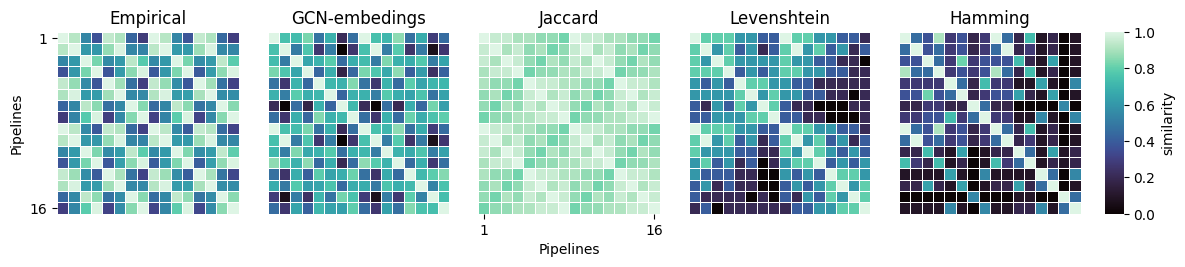

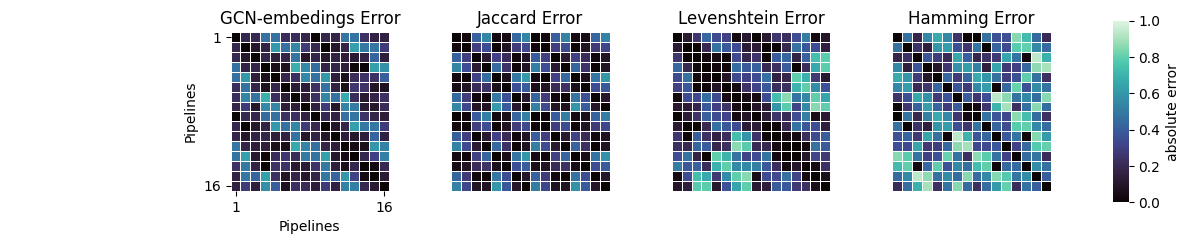

In [13]:
import matplotlib.gridspec as gridspec

similarity_matrices = [
    (empirical_similarity, "Empirical"),
    (gcn_similarity, "GCN-embedings"),
    (jaccard_similarity, "Jaccard"),
    (levenshtein_similarity, "Levenshtein"),
    (hamming_similarity, "Hamming")
]

absolute_error_matrices = [
    (abs(gcn_similarity - empirical_similarity), "GCN-embedings Error"),
    (abs(jaccard_similarity - empirical_similarity), "Jaccard Error"),
    (abs(levenshtein_similarity - empirical_similarity), "Levenshtein Error"),
    (abs(hamming_similarity - empirical_similarity), "Hamming Error")
]

# Set up figure and gridspec
fig = plt.figure(figsize=(12, 2.45))
gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], figure=fig)
cbar_ax = fig.add_subplot(gs[0, 5])

# Plot similarity matrices
for i, (matrix, title) in enumerate(similarity_matrices):
    ax = fig.add_subplot(gs[0, i])
    sns.heatmap(matrix, cmap="mako", ax=ax, vmin=0, vmax=1, square=True, linewidths=0.5,
                cbar=(i == 4), cbar_ax=cbar_ax if i == 4 else None, cbar_kws={'label': 'similarity'})
    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Pipelines', fontsize=10)
        ax.set_yticks([0.5, 15.5])
        ax.set_yticklabels([1, 16], rotation=0)
    if i == 2:
        ax.set_xlabel('Pipelines', fontsize=10)
        ax.set_xticks([0.5, 15.5])
        ax.set_xticklabels([1, 16])


# Adjust layout and save
plt.tight_layout()
plt.savefig("figures/predictions.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()

# Set up figure and gridspec
fig = plt.figure(figsize=(12, 2.45))
gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], figure=fig)
cbar_ax = fig.add_subplot(gs[0, 5])

for i in range(len(absolute_error_matrices) + 1):
    ax = fig.add_subplot(gs[0, i])
    if i == 0:
        ax.axis('off')
    else:
        matrix, title = absolute_error_matrices[i - 1]
        sns.heatmap(matrix, cmap="mako", ax=ax, vmin=0, vmax=1, square=True, linewidths=0.5,
                    cbar=(i == 4), cbar_ax=cbar_ax if i == 4 else None, cbar_kws={'label': 'absolute error'})
        ax.set_title(title, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 1:
            ax.set_ylabel('Pipelines', fontsize=10)
            ax.set_xlabel('Pipelines', fontsize=10)
            ax.set_yticks([0.5, 15.5])
            ax.set_yticklabels([1, 16], rotation=0)
            ax.set_xticks([0.5, 15.5])
            ax.set_xticklabels([1, 16])

plt.tight_layout()
#plt.savefig("figures/absolute_error_matrices.pdf")
plt.show()

In [14]:
empirical_upper = empirical_similarity[np.triu_indices_from(empirical_similarity, k=1)]
gcn_upper = gcn_similarity[np.triu_indices_from(gcn_similarity, k=1)]
levenshtein_upper = levenshtein_similarity[np.triu_indices_from(levenshtein_similarity, k=1)]
hamming_upper = hamming_similarity[np.triu_indices_from(hamming_similarity, k=1)]
jaccard_upper = jaccard_similarity[np.triu_indices_from(jaccard_similarity, k=1)]

similarity_data = pd.DataFrame({
    'Empirical': empirical_upper,
    'GCN-embedings': gcn_upper,
    'Jaccard': jaccard_upper,
    'Levenshtein': levenshtein_upper, 
    'Hamming': hamming_upper
})

# Calculate absolute errors
absolute_errors = {
    'GCN-embedings': np.abs(similarity_data['Empirical'] - similarity_data['GCN-embedings']),
    'Jaccard': np.abs(similarity_data['Empirical'] - similarity_data['Jaccard']),
    'Levenshtein': np.abs(similarity_data['Empirical'] - similarity_data['Levenshtein']),
    'Hamming': np.abs(similarity_data['Empirical'] - similarity_data['Hamming']),
}

absolute_errors_df = pd.DataFrame(absolute_errors)
absolute_errors_df_melted = absolute_errors_df.melt(var_name='Method', value_name='Absolute Error') # melt the DataFrame for visualization

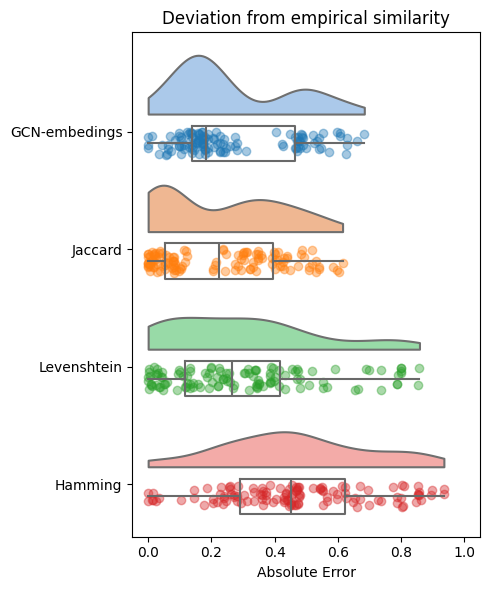


Median Absolute Errors:
 GCN-embedings    0.184273
Jaccard          0.225006
Levenshtein      0.264332
Hamming          0.451240
dtype: float64


In [15]:
data = absolute_errors_df_melted.copy()

METHOD = ["GCN-embedings", "Jaccard", "Levenshtein", "Hamming"]
SHIFT = 0.1
POSITIONS = [0 + SHIFT, 1 + SHIFT, 2 + SHIFT, 3 + SHIFT]

boxplot_data = [data[data["Method"] == method]["Absolute Error"].values for method in METHOD]

medianprops = {"linewidth": 1.5, "color": "#696969", "solid_capstyle": "butt"}
boxprops = {"linewidth": 1.5, "color": "#696969"}


# Plotting
fig, ax = plt.subplots(figsize=(5, 6))

# Plot the half-violin plots
pt.half_violinplot(x="Absolute Error", y="Method", inner=None, data=data, width=1, ax=ax, cut=0, palette="pastel")

# Scatter points
for i, method in enumerate(METHOD):
    method_data = data[data["Method"] == method]
    y = i + np.random.uniform(high=0.2, size=len(method_data))  # Add jitter
    x = method_data["Absolute Error"]
    ax.scatter(x, y, alpha=0.4)

# Boxplots
ax.boxplot(
    boxplot_data,
    vert=False,
    positions=POSITIONS,
    widths=0.3, 
    manage_ticks=False,
    showfliers=False,
    showcaps=False,
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Axes and labels
ax.set_xlim(-0.05,1.05)
ax.set_xlabel("Absolute Error", fontsize=10)
ax.set_ylabel("")
ax.set_title("Deviation from empirical similarity", fontsize=12)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("figures/performance.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()

# Calculate median absollute errors
median_errors = absolute_errors_df.median()
print("\nMedian Absolute Errors:\n", median_errors)

In [16]:
# Z-score the similarity matrices
gcn_similarity_z = zscore(gcn_similarity)
hamming_similarity_z = zscore(hamming_similarity)
levenshtein_similarity_z = zscore(levenshtein_similarity)

# Calculate dissimilarity matrices
diss_dtw_hamming = np.abs(gcn_similarity_z - hamming_similarity_z)
diss_dtw_levenshtein = np.abs(gcn_similarity_z - levenshtein_similarity_z)
diss_hamming_levenshtein = np.abs(hamming_similarity_z - levenshtein_similarity_z)

def find_top_pairs(dissimilarity_matrix):
    n_pipelines = dissimilarity_matrix.shape[0]
    pairs = [(i, j) for i in range(n_pipelines) for j in range(i + 1, n_pipelines)]
    differences = [(dissimilarity_matrix[i, j], (i, j)) for i, j in pairs]
    differences.sort(reverse=True, key=lambda x: x[0])

    top_differences = [diff[0] for diff in differences[:10]]
    top_pairs = [diff[1] for diff in differences[:10]]

    return top_pairs, top_differences

# Find the top pairs for each dissimilarity matrix
top_dtw_hamming_pairs, top_dtw_hamming_diffs = find_top_pairs(diss_dtw_hamming)
top_dtw_levenshtein_pairs, top_dtw_levenshtein_diffs = find_top_pairs(diss_dtw_levenshtein)
top_hamming_levenshtein_pairs, top_hamming_levenshtein_diffs = find_top_pairs(diss_hamming_levenshtein)

# Print the results
def print_top_pairs(top_pairs, top_diffs, title, sim_matrix1, sim_matrix2):
    print(title)
    for idx, (i, j) in enumerate(top_pairs):
        diff = top_diffs[idx]
        print(f"Pair ({i}, {j}) has a dissimilarity of {diff}")
        print(f"Pipeline {i}: {pipelines[i]}")
        print(f"Pipeline {j}: {pipelines[j]}")
        print(f"Similarity by first measure: {sim_matrix1[i, j]}")
        print(f"Similarity by second measure: {sim_matrix2[i, j]}")
        print()

print_top_pairs(top_dtw_hamming_pairs, top_dtw_hamming_diffs, "Top pairs for Embedding Similarity (DTW) vs Hamming Similarity:", gcn_similarity_z, hamming_similarity_z)
print_top_pairs(top_dtw_levenshtein_pairs, top_dtw_levenshtein_diffs, "Top pairs for Embedding Similarity (DTW) vs Levenshtein Similarity:", gcn_similarity_z, levenshtein_similarity_z)
print_top_pairs(top_hamming_levenshtein_pairs, top_hamming_levenshtein_diffs, "Top pairs for Hamming Similarity vs Levenshtein Similarity:", hamming_similarity_z, levenshtein_similarity_z)

Top pairs for Embedding Similarity (DTW) vs Hamming Similarity:
Pair (12, 14) has a dissimilarity of 1.5453677897906968
Pipeline 12: ['Software', 'S-Skull_stripping', 'S-BBR_crossmodal_registration', 'S-INU_correction', 'S-Gradient_Distortion_Correction', 'F-Alignment/Head_motion_est', 'F-Field_map_correction', 'F-Unwarp', 'F-Coregistration', 'F-Spatial_normalization', 'F-Intensity_normalization', 'F-surface', 'F-motion_regression', 'F-Other_confound_regression', 'Atlas_definition', 'ROI_definition', 'F-Temporal_filt', 'Compute_connectivity', 'Connectivity_normalization', 'Graph_characteristics', 'Sparsity_control', 'Graph_measures']
Pipeline 14: ['Software', 'S-Skull_stripping', 'S-BBR_crossmodal_registration', 'S-INU_correction', 'S-Gradient_Distortion_Correction', 'F-Alignment/Head_motion_est', 'F-Field_map_correction', 'F-Unwarp', 'F-Coregistration', 'F-Spatial_normalization', 'F-Intensity_normalization', 'F-surface', 'F-Global_signal', 'F-motion_regression', 'F-Other_confound_regr

In [17]:
pipeline_df = pd.read_excel(f'{wd}/data/Database_clean.xlsx')
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
authors = [pipeline[0] for pipeline in pipelines]
pipelines = [pipeline[1:] for pipeline in pipelines]


######################
# PARAMETER DEFINITION
n_top_pairs = 10
n_repetitions = 10

def find_top_pairs(dissimilarity_matrix):
    n_pipelines = dissimilarity_matrix.shape[0]
    pairs = [(i, j) for i in range(n_pipelines) for j in range(i + 1, n_pipelines)]
    differences = [(dissimilarity_matrix[i, j], (i, j)) for i, j in pairs]
    differences.sort(reverse=True, key=lambda x: x[0])

    top_differences = [diff[0] for diff in differences[:n_top_pairs]]
    top_pairs = [diff[1] for diff in differences[:n_top_pairs]]

    return top_pairs, top_differences

# Initialize lists to store the results from each run
all_dtw_hamming_pairs = []
all_dtw_levenshtein_pairs = []
all_hamming_levenshtein_pairs = []

all_dtw_hamming_diff = []
all_dtw_levenshtein_diff = []
all_hamming_levenshtein_diff = []

# Run the a few times for better estimate
for _ in range(n_repetitions):
    embeddings = run_deep_graph_infomax(G, layer_sizes=[32], activations=["relu"], epochs=150, learning_rate=1e-2, pat=80)
    embedding_dict = {label: emb for label, emb in zip(nodes, embeddings)}

    # DTW
    pipeline_embeddings_dtw = []
    for pipeline in pipelines:
        pipeline_embs = [embedding_dict[node] for node in pipeline if node in embedding_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

    joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw, index=authors)
    dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
    min_val = np.min(dissimilarity_matrix)
    max_val = np.max(dissimilarity_matrix)
    scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
    embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

    # Levenshtein
    n = len(pipelines)
    levenshtein_distance = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

    min_val = np.min(levenshtein_distance)
    max_val = np.max(levenshtein_distance)
    scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
    levenshtein_similarity = 1 - scaled_levenshtein_distance

    # Hamming
    hamming_distance = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

    min_val = np.min(hamming_distance)
    max_val = np.max(hamming_distance)
    scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
    hamming_similarity = 1 - scaled_hamming_distance

    embedding_similarity_dtw_z = zscore(embedding_similarity_dtw)
    hamming_similarity_z = zscore(hamming_similarity)
    levenshtein_similarity_z = zscore(levenshtein_similarity)

    diff_dtw_hamming = np.abs(embedding_similarity_dtw_z - hamming_similarity_z)
    diff_dtw_levenshtein = np.abs(embedding_similarity_dtw_z - levenshtein_similarity_z)
    diff_hamming_levenshtein = np.abs(hamming_similarity_z - levenshtein_similarity_z)

    top_dtw_hamming_pairs, top_dtw_hamming_diff = find_top_pairs(diff_dtw_hamming)
    top_dtw_levenshtein_pairs, top_dtw_levenshtein_diff = find_top_pairs(diff_dtw_levenshtein)
    top_hamming_levenshtein_pairs, top_hamming_levenshtein_diff = find_top_pairs(diff_hamming_levenshtein)

    # Accumulate the pairs
    all_dtw_hamming_pairs.extend(top_dtw_hamming_pairs)
    all_dtw_levenshtein_pairs.extend(top_dtw_levenshtein_pairs)
    all_hamming_levenshtein_pairs.extend(top_hamming_levenshtein_pairs)

    # Accumulate the differences
    all_dtw_hamming_diff.extend(top_dtw_hamming_diff)
    all_dtw_levenshtein_diff.extend(top_dtw_levenshtein_diff)
    all_hamming_levenshtein_diff.extend(top_hamming_levenshtein_diff)

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 51ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 30ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 28ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 26ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 26ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 27ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 44ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 44ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 29ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 31ms/step


In [18]:
def calculate_length(pipelines, pairs, sim_mat1, sim_mat2):
    length_differences = []
    measure1_more_similar_count = 0

    for (idx1, idx2) in pairs:
        # Pipeline length difference
        p1_length = len(pipelines[idx1])
        p2_length = len(pipelines[idx2])
        length_differences.append(abs(p1_length - p2_length))

        # Direction of similarity judgment
        if sim_mat1[idx1, idx2] > sim_mat2[idx1, idx2]:
            measure1_more_similar_count += 1

    return length_differences, measure1_more_similar_count

# Calculate the average length differences, direction counts, and similarity judgments
length_diff_dtw_hamming, measure1_more_similar_count_dtw_hamming = calculate_length(pipelines, all_dtw_hamming_pairs, embedding_similarity_dtw_z, hamming_similarity_z)
length_diff_dtw_levenshtein, measure1_more_similar_count_dtw_levenshtein = calculate_length(pipelines, all_dtw_levenshtein_pairs, embedding_similarity_dtw_z, levenshtein_similarity_z)
length_diff_hamming_levenshtein, measure1_more_similar_count_hamming_levenshtein = calculate_length(pipelines, all_hamming_levenshtein_pairs, hamming_similarity_z, levenshtein_similarity_z)

# Print the results
print("Mean length difference between pipelines:")
print(f"DTW vs Hamming: {np.mean(length_diff_dtw_hamming)}")
print(f"DTW vs Levenshtein: {np.mean(length_diff_dtw_levenshtein)}")
print(f"Hamming vs Levenshtein: {np.mean(length_diff_hamming_levenshtein)}")

print("\nDirection of similarity judgment:")
print(f"DTW vs Hamming: DTW judges more similar {measure1_more_similar_count_dtw_hamming} of {len(length_diff_dtw_hamming)} times")
print(f"DTW vs Levenshtein: DTW judges more similar {measure1_more_similar_count_dtw_levenshtein} of {len(length_diff_dtw_levenshtein)} times")
print(f"Hamming vs Levenshtein: Hamming judges more similar {measure1_more_similar_count_hamming_levenshtein} of {len(length_diff_hamming_levenshtein)} times")


Mean length difference between pipelines:
DTW vs Hamming: 10.01
DTW vs Levenshtein: 6.85
Hamming vs Levenshtein: 0.2

Direction of similarity judgment:
DTW vs Hamming: DTW judges more similar 0 of 100 times
DTW vs Levenshtein: DTW judges more similar 38 of 100 times
Hamming vs Levenshtein: Hamming judges more similar 90 of 100 times


In [19]:
def calculate_switching(pipelines, pairs, sim_mat1, sim_mat2):
    switch_count = 0
    total_count = 0
    measure1_more_similar_count = 0

    for first_pipeline, second_pipeline in pairs:

        pipeline1 = pipelines[first_pipeline]
        pipeline2 = pipelines[second_pipeline]

        # Get the index of Atlas_definition, if it exists
        idx_parc1 = pipeline1.index("Atlas_definition") if "Atlas_definition" in pipeline1 else None
        idx_parc2 = pipeline2.index("Atlas_definition") if "Atlas_definition" in pipeline2 else None

        # Get the indices of the cleaning steps, if they exist
        idx_c11 = pipeline1.index("F-Temporal_filt") if "F-Temporal_filt" in pipeline1 else None
        idx_c21 = pipeline1.index("F-motion_regression") if "F-motion_regression" in pipeline1 else None
        idx_c31 = pipeline1.index("F-Other_confound_regression") if "F-Other_confound_regression" in pipeline1 else None

        idx_c12 = pipeline2.index("F-Temporal_filt") if "F-Temporal_filt" in pipeline2 else None
        idx_c22 = pipeline2.index("F-motion_regression") if "F-motion_regression" in pipeline2 else None
        idx_c32 = pipeline2.index("F-Other_confound_regression") if "F-Other_confound_regression" in pipeline2 else None

        # Build a list of valid comparison indices for each pipeline
        idx_c1_list = [idx for idx in [idx_c11, idx_c21, idx_c31] if idx is not None]
        idx_c2_list = [idx for idx in [idx_c12, idx_c22, idx_c32] if idx is not None]

        # Check if both pipelines have atlas definitiona and at least one of the cleaning options
        if (idx_parc1 is not None and idx_c1_list) and (idx_parc2 is not None and idx_c2_list):
            total_count += 1

        # Switching conditions indeendent of the order
        if idx_parc1 is not None and idx_c1_list:
            parc1_condition = any(idx_parc1 < idx_c for idx_c in idx_c1_list)
            parc1_opposite_condition = any(idx_parc1 > idx_c for idx_c in idx_c1_list)
        else:
            parc1_condition = parc1_opposite_condition = False

        if idx_parc2 is not None and idx_c2_list:
            parc2_condition = any(idx_parc2 > idx_c for idx_c in idx_c2_list)
            parc2_opposite_condition = any(idx_parc2 < idx_c for idx_c in idx_c2_list)
        else:
            parc2_condition = parc2_opposite_condition = False

        # If both conditions hold for either the original or opposite check, increment the switch count
        if (parc1_condition and parc2_condition) or (parc1_opposite_condition and parc2_opposite_condition):
            switch_count += 1

            if sim_mat1[first_pipeline, second_pipeline] > sim_mat2[first_pipeline, second_pipeline]:
                measure1_more_similar_count += 1

    return switch_count, total_count, measure1_more_similar_count


switch_count, total_count, measure1_more_similar_count = calculate_switching(pipelines, all_dtw_hamming_pairs, embedding_similarity_dtw_z, hamming_similarity_z)
print(f"DTW-Hamming switch clean/parcellation order in {switch_count / total_count * 100}% of comparisons ({switch_count}/{total_count})")
print(f"If a switch is present, DTW judged more similar {measure1_more_similar_count} of {switch_count} times\n")

switch_count, total_count, measure1_more_similar_count = calculate_switching(pipelines, all_dtw_levenshtein_pairs, embedding_similarity_dtw_z, levenshtein_similarity_z)
print(f"DTW-Levenshtein switch clean/parcellation order in {switch_count / total_count * 100}% of comparisons ({switch_count}/{total_count})")
print(f"If a switch is present, DTW judged more similar {measure1_more_similar_count} of {switch_count} times\n")

switch_count, total_count, measure1_more_similar_count = calculate_switching(pipelines, all_hamming_levenshtein_pairs, hamming_similarity_z, levenshtein_similarity_z)
print(f"Hamming-Levenshtein switch clean/parcellation order in {switch_count / total_count * 100}% of comparisons ({switch_count}/{total_count})")
print(f"If a switch is present, Hamming judged more similar {measure1_more_similar_count} of {switch_count} times")

DTW-Hamming switch clean/parcellation order in 13.580246913580247% of comparisons (11/81)
If a switch is present, DTW judged more similar 0 of 11 times

DTW-Levenshtein switch clean/parcellation order in 45.83333333333333% of comparisons (33/72)
If a switch is present, DTW judged more similar 32 of 33 times

Hamming-Levenshtein switch clean/parcellation order in 0.0% of comparisons (0/70)
If a switch is present, Hamming judged more similar 0 of 0 times
